# A Simplified Bayesian Optimization
## Said Bolluk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
data_directory = r"Local Directory"
mydf = pd.read_csv(os.path.join(data_directory, "optimization_results.csv"))
mydf = mydf.drop(columns="Unnamed: 0")
mydf.head()

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,NG_MAPE,NG_CV-RMSE,Elec_MAPE,Elec_CV-RMSE,TOE_MAPE,TOE_CV-RMSE
0,S1,0.000071,5.0,20.0,0.1,3.0,0.731496,0.775969,0.527558,0.534469,0.669916,0.712989
1,S2,0.000071,5.0,20.0,0.1,4.5,0.738793,0.789172,0.447447,0.455582,0.653534,0.705876
2,S3,0.000071,5.0,20.0,0.1,6.0,0.746784,0.802442,0.361996,0.372956,0.636123,0.697789
3,S4,0.000071,5.0,20.0,0.1,7.5,0.754824,0.818600,0.271204,0.288367,0.617486,0.690827
4,S5,0.000071,5.0,20.0,0.1,9.0,0.762410,0.832801,0.188112,0.215208,0.599854,0.683658


In [3]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Scenario           3125 non-null   object 
 1   dhw_flow_rate      3125 non-null   float64
 2   equipment_density  3125 non-null   float64
 3   heating_set_point  3125 non-null   float64
 4   infiltration       3125 non-null   float64
 5   lighting_density   3125 non-null   float64
 6   NG_MAPE            3125 non-null   float64
 7   NG_CV-RMSE         3125 non-null   float64
 8   Elec_MAPE          3125 non-null   float64
 9   Elec_CV-RMSE       3125 non-null   float64
 10  TOE_MAPE           3125 non-null   float64
 11  TOE_CV-RMSE        3125 non-null   float64
dtypes: float64(11), object(1)
memory usage: 293.1+ KB


# Baseline Combo

In [4]:
baseline_id = "S1563"
baseline_combo = mydf[mydf["Scenario"]==baseline_id]
baseline_combo

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,NG_MAPE,NG_CV-RMSE,Elec_MAPE,Elec_CV-RMSE,TOE_MAPE,TOE_CV-RMSE
1562,S1563,0.00039,7.5,21.5,0.3,6.0,0.178369,0.23555,0.215868,0.24048,0.149054,0.196449


# Choosing the best parameter combination

# 1) Deterministic Calibration

Choose the scenario with the least simulation error based on CV-RMSE of the TOE:

In [5]:
mydf.sort_values(by="TOE_CV-RMSE", ascending=True)[:10]

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,NG_MAPE,NG_CV-RMSE,Elec_MAPE,Elec_CV-RMSE,TOE_MAPE,TOE_CV-RMSE
1940,S1941,0.000549,5.00,21.5,0.4,3.0,0.259933,0.158856,0.466441,0.477716,0.068876,0.079804
2190,S2191,0.000549,7.50,21.5,0.4,3.0,0.258598,0.157323,0.383440,0.393334,0.074834,0.081338
2065,S2066,0.000549,6.25,21.5,0.4,3.0,0.259888,0.160988,0.443668,0.453250,0.072787,0.081570
1941,S1942,0.000549,5.00,21.5,0.4,4.5,0.261339,0.162712,0.433668,0.443825,0.074807,0.082118
1942,S1943,0.000549,5.00,21.5,0.4,6.0,0.257079,0.156397,0.358759,0.369610,0.077610,0.082791
2315,S2316,0.000549,8.75,21.5,0.4,3.0,0.254452,0.155622,0.304484,0.324092,0.085483,0.086995
2066,S2067,0.000549,6.25,21.5,0.4,4.5,0.261771,0.164764,0.373440,0.383674,0.083462,0.090095
1943,S1944,0.000549,5.00,21.5,0.4,7.5,0.256245,0.157301,0.279168,0.298776,0.090453,0.090265
2191,S2192,0.000549,7.50,21.5,0.4,4.5,0.257067,0.160842,0.308530,0.325863,0.089262,0.091063
2067,S2068,0.000549,6.25,21.5,0.4,6.0,0.257676,0.160751,0.298531,0.316141,0.090078,0.091371


In [6]:
dc_optimal_id = "S1941"
dc_optimal_combo = mydf[mydf["Scenario"]==dc_optimal_id]
dc_optimal_combo

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,NG_MAPE,NG_CV-RMSE,Elec_MAPE,Elec_CV-RMSE,TOE_MAPE,TOE_CV-RMSE
1940,S1941,0.000549,5.0,21.5,0.4,3.0,0.259933,0.158856,0.466441,0.477716,0.068876,0.079804


# 2) Probabilistic Calibration: Bayes Classifier

Label scenarios based on TOE_CV-RMSE

In [7]:
data = mydf.copy()

# Define a random error rate for the decision boundary
error_rate = 0
decision_boundary = 0.15 + error_rate

# Label scenarios based on the CV-RMSE and the decision boundary
for i in range(data.shape[0]):
    
    if data.loc[i, "TOE_CV-RMSE"] <= decision_boundary:
        data.loc[i, "Label"] = 1
    else:
        data.loc[i, "Label"] = 0
        
data["Label"].value_counts()

Label
0.0    2774
1.0     351
Name: count, dtype: int64

In [8]:
necessary_columns = [
    'Scenario', 'dhw_flow_rate', 'equipment_density', 
    'heating_set_point', 'infiltration', 'lighting_density',
    'TOE_CV-RMSE', 'TOE_MAPE', 'Label',
]

new_df = data[necessary_columns]
new_df.head()

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,TOE_CV-RMSE,TOE_MAPE,Label
0,S1,0.000071,5.0,20.0,0.1,3.0,0.712989,0.669916,0.0
1,S2,0.000071,5.0,20.0,0.1,4.5,0.705876,0.653534,0.0
2,S3,0.000071,5.0,20.0,0.1,6.0,0.697789,0.636123,0.0
3,S4,0.000071,5.0,20.0,0.1,7.5,0.690827,0.617486,0.0
4,S5,0.000071,5.0,20.0,0.1,9.0,0.683658,0.599854,0.0


Visualization

In [9]:
from scipy.stats import percentileofscore

# Assuming new_df["TOE_CV-RMSE"] contains your data
target_value = 0.15
percentile_value = percentileofscore(new_df["TOE_CV-RMSE"], target_value)
print(f"The percentile value corresponding to {target_value} is: {percentile_value:.3f}")

The percentile value corresponding to 0.15 is: 11.232


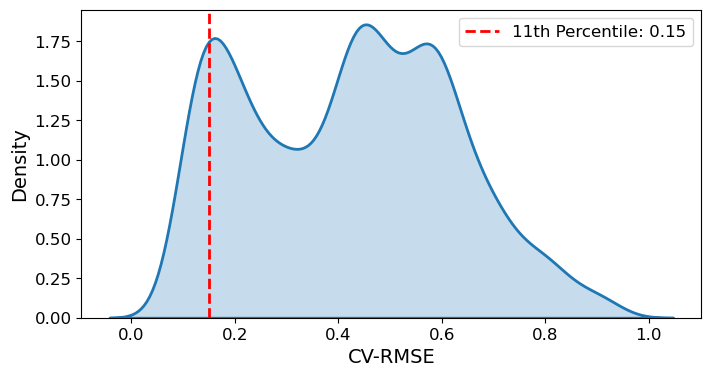

In [10]:
# Create a kernel density estimate plot (PDF) for the "TOE_CV-RMSE" column
plt.figure(figsize=(8, 4), dpi=100)
sns.kdeplot(new_df["TOE_CV-RMSE"], linewidth=2, fill=True)

# Plot red dashed lines for the 1st and 99th percentiles
percentile = np.round(percentile_value, 2)
border = 0.15
plt.axvline(border, color='red', linestyle='--', linewidth=2, label=f'{percentile:.0f}th Percentile: {border}')

plt.xlabel("CV-RMSE", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title("Probability Density Function (PDF) of TOE_CV-RMSE", fontsize=16)  # Uncomment this line to add a title
plt.legend(fontsize=12)
plt.show()

## 2.1) Choosing from available scenarios

In [11]:
# Scale data
X = new_df.drop(columns=["Scenario", "TOE_CV-RMSE", "TOE_MAPE", "Label"])
y = new_df["Label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

bayes = GaussianNB()
bayes.fit(X_scaled, y)
preds = bayes.predict(X_scaled)

# Count occurrences of 1 and 0 in preds
counts = np.bincount(preds.astype(int))
# Print counts
print("Counts of 0:", counts[0])
print("Counts of 1:", counts[1])

print("\n", classification_report(y, preds))

Counts of 0: 2887
Counts of 1: 238

               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      2774
         1.0       0.71      0.48      0.57       351

    accuracy                           0.92      3125
   macro avg       0.82      0.73      0.76      3125
weighted avg       0.91      0.92      0.91      3125



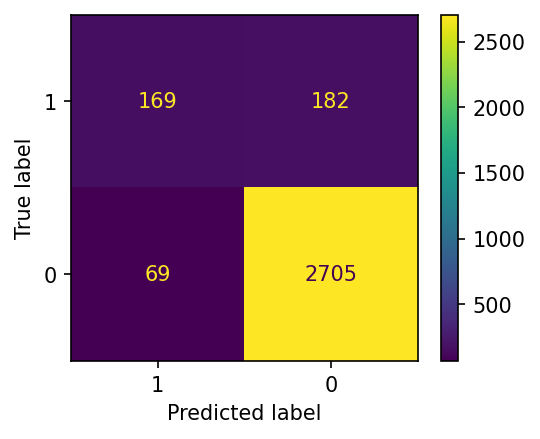

In [12]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
labels = [1, 0]
cm = confusion_matrix(y, preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
#plt.title("Scoring: Precision")
plt.show()

In [13]:
# Scenario probabilitites
proba_df = pd.DataFrame(bayes.predict_proba(X_scaled), columns=['Probability_Class_0', 'Probability_Class_1'])
result_df = pd.concat([new_df.reset_index(drop=True), proba_df], axis=1)
sorted_df = result_df.sort_values(by="Probability_Class_1", ascending=False)
sorted_df.head(10)

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,TOE_CV-RMSE,TOE_MAPE,Label,Probability_Class_0,Probability_Class_1
2545,S2546,0.000709,5.00,20.75,0.5,3.0,0.134309,0.138233,1.0,0.188445,0.811555
2670,S2671,0.000709,6.25,20.75,0.5,3.0,0.136247,0.146280,1.0,0.195330,0.804670
2546,S2547,0.000709,5.00,20.75,0.5,4.5,0.139455,0.146608,1.0,0.200816,0.799184
2795,S2796,0.000709,7.50,20.75,0.5,3.0,0.142008,0.154232,1.0,0.202104,0.797896
2671,S2672,0.000709,6.25,20.75,0.5,4.5,0.140116,0.154659,1.0,0.208037,0.791963
2920,S2921,0.000709,8.75,20.75,0.5,3.0,0.142982,0.165461,1.0,0.208745,0.791255
2547,S2548,0.000709,5.00,20.75,0.5,6.0,0.142564,0.157583,1.0,0.214954,0.785046
2796,S2797,0.000709,7.50,20.75,0.5,4.5,0.145559,0.167626,1.0,0.215134,0.784866
3045,S3046,0.000709,10.00,20.75,0.5,3.0,0.148036,0.173685,1.0,0.215232,0.784768
2921,S2922,0.000709,8.75,20.75,0.5,4.5,0.148798,0.176004,1.0,0.222084,0.777916


# 2.2.) Parametric estimation: mean and variance

In [14]:
mean_list = scaler.inverse_transform(bayes.theta_)
var_list = scaler.inverse_transform(bayes.var_)

print("Estimated Means:", mean_list)
print("Estimated Variances:", var_list)

Estimated Means: [[3.61831110e-04 7.51171593e+00 2.15716474e+01 2.88680606e-01
  6.02974045e+00]
 [6.10663818e-04 7.40740741e+00 2.09337607e+01 3.89458689e-01
  5.76495726e+00]]
Estimated Variances: [[6.06125549e-04 9.26641478e+00 2.26145123e+01 4.42095761e-01
  8.12128575e+00]
 [4.44843042e-04 9.27298986e+00 2.17945202e+01 3.72342406e-01
  8.09225574e+00]]


In [15]:
# Expected mean and variances for each parameter: Label==0
print("LABEL==0 >>>")
param_list = X.columns
for i in range(len(mean_list[0])):
    mean = mean_list[0][i]
    variance = var_list[0][i]

    # Create a normal distribution for the current parameter
    dist = norm(loc=mean, scale=np.sqrt(variance))

    # Calculate the expected value (mean) for the current parameter
    expected_value = dist.mean()
    
    if param_list[i] == "dhw_flow_rate":
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value}")
    else:
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value:.3f}")

LABEL==0 >>>
Expected value (mean) for Parameter dhw_flow_rate: 0.0003618311103100248
Expected value (mean) for Parameter equipment_density: 7.512
Expected value (mean) for Parameter heating_set_point: 21.572
Expected value (mean) for Parameter infiltration: 0.289
Expected value (mean) for Parameter lighting_density: 6.030


In [16]:
# Expected mean and variances for each parameter: Label==1
print("\nLABEL==1 >>>")
for i in range(len(mean_list[1])):
    mean = mean_list[1][i]
    variance = var_list[1][i]

    # Create a normal distribution for the current parameter
    dist = norm(loc=mean, scale=np.sqrt(variance))

    # Calculate the expected value (mean) for the current parameter
    expected_value = dist.mean()
    
    if param_list[i] == "dhw_flow_rate":
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value} >> STD: {np.sqrt(variance)/expected_value:.2f}")
    else:
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value:.3f} >> STD: {np.sqrt(variance)/expected_value:.2f}")


LABEL==1 >>>
Expected value (mean) for Parameter dhw_flow_rate: 0.0006106638176638178 >> STD: 34.54
Expected value (mean) for Parameter equipment_density: 7.407 >> STD: 0.41
Expected value (mean) for Parameter heating_set_point: 20.934 >> STD: 0.22
Expected value (mean) for Parameter infiltration: 0.389 >> STD: 1.57
Expected value (mean) for Parameter lighting_density: 5.765 >> STD: 0.49


## Comparing Likelihood and Posteriror Distributions: infiltration_rate

In [17]:
mydf["infiltration"].value_counts()

infiltration
0.1    625
0.2    625
0.3    625
0.4    625
0.5    625
Name: count, dtype: int64

In [18]:
param_index = 3
average = mean_list[1][param_index]
var = var_list[1][param_index]
std = np.sqrt(var_list[1][param_index])

print("Selected simulation parameter: Infiltration Rate")
print(f"Mean: {average:.3f}")
print(f"Std.: {std:.3f}")

Selected simulation parameter: Infiltration Rate
Mean: 0.389
Std.: 0.610


In [19]:
mydf.groupby(by="infiltration")["TOE_CV-RMSE"].mean()

infiltration
0.1    0.460748
0.2    0.435681
0.3    0.413924
0.4    0.400494
0.5    0.396284
Name: TOE_CV-RMSE, dtype: float64

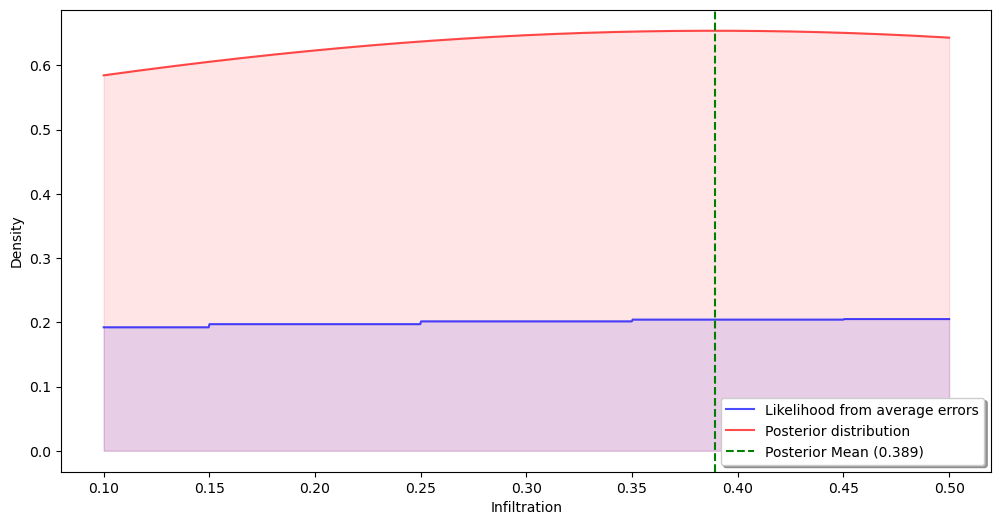

In [20]:
infiltration_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
average_errors = np.array([0.460748, 0.435681, 0.413924, 0.400494, 0.396284])

# Normalize the errors to get likelihoods
likelihoods = np.exp(-average_errors)
likelihoods /= likelihoods.sum()

# Posterior distribution parameters
posterior_mean = 0.389
posterior_std = 0.610

# Define the x range for the plots
x = np.linspace(0.1, 0.5, 1000)

# Likelihood as a piecewise constant PDF
likelihood_pdf = np.zeros_like(x)
for i in range(len(infiltration_values)):
    if i == 0:
        likelihood_pdf[(x >= 0) & (x <= (infiltration_values[i] + infiltration_values[i+1])/2)] = likelihoods[i]
    elif i == len(infiltration_values) - 1:
        likelihood_pdf[(x > (infiltration_values[i-1] + infiltration_values[i])/2) & (x <= 1)] = likelihoods[i]
    else:
        likelihood_pdf[(x > (infiltration_values[i-1] + infiltration_values[i])/2) & (x <= (infiltration_values[i] + infiltration_values[i+1])/2)] = likelihoods[i]

# Posterior distribution
posterior_pdf = norm.pdf(x, posterior_mean, posterior_std)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x, likelihood_pdf, 'b-', label='Likelihood from average errors', alpha=0.7)
plt.fill_between(x, 0, likelihood_pdf, color='blue', alpha=0.1)
plt.plot(x, posterior_pdf, 'r-', label='Posterior distribution', alpha=0.7)
plt.fill_between(x, 0, posterior_pdf, color='red', alpha=0.1)

# Add a dashed vertical line for the expected value of the posterior distribution
plt.axvline(posterior_mean, color='green', linestyle="--", label=f'Posterior Mean ({posterior_mean:.3f})')

# Formatting the plot
#plt.title('Likelihood and Posterior Distributions for Infiltration')
plt.xlabel('Infiltration')
plt.ylabel('Density')

# Adding the legend with custom position and formatting
plt.legend(
    loc='lower right',    
    bbox_to_anchor=(1, 0),
    ncol=1,               
    frameon=True,         
    shadow=True           
)

plt.grid(False)
plt.savefig('likelihood_posterior_distributions.png', dpi=150)
plt.show()

# END